In [1]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 66 kB 617 kB/s eta 0:00:01
     |████████████████████████████████| 58 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 244 kB 3.0 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=3d8b2e65da14beacf764b6c0ddfb1ad29c1173e54cba4f8e9dd31dd6107bc05c
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=65813ed1c7c343608509725b0be4d4b470d19d76a83e929e1a5ed06223fcf599
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid-segmentation/masks_medseg.npy
/kaggle/input/covid-segmentation/images_medseg.npy
/kaggle/input/covid-segmentation/test_images_medseg.npy
/kaggle/input/covid-segmentation/masks_radiopedia.npy
/kaggle/input/covid-segmentation/images_radiopedia.npy


In [3]:
prefix = '/kaggle/input/covid-segmentation/'

images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [4]:
def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8, hot_encode=True):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))

    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        if hot_encode: 
            ax_image.imshow(image_batch[i,:,:,0], cmap='Greys')
        else: 
            ax_image.imshow(image_batch[i,:,:])
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()

### Images from radiopedia are full CT volumes:
Class 0 is "ground glass"<br>
Class 1 is "consolidations"<br>
Class 2 is "lungs other" – it doesn't mean that it is healthy lungs (you don't need to predict this class)<br>
Class 3 is "background" – not lungs (you don't need to predict this class)<br>

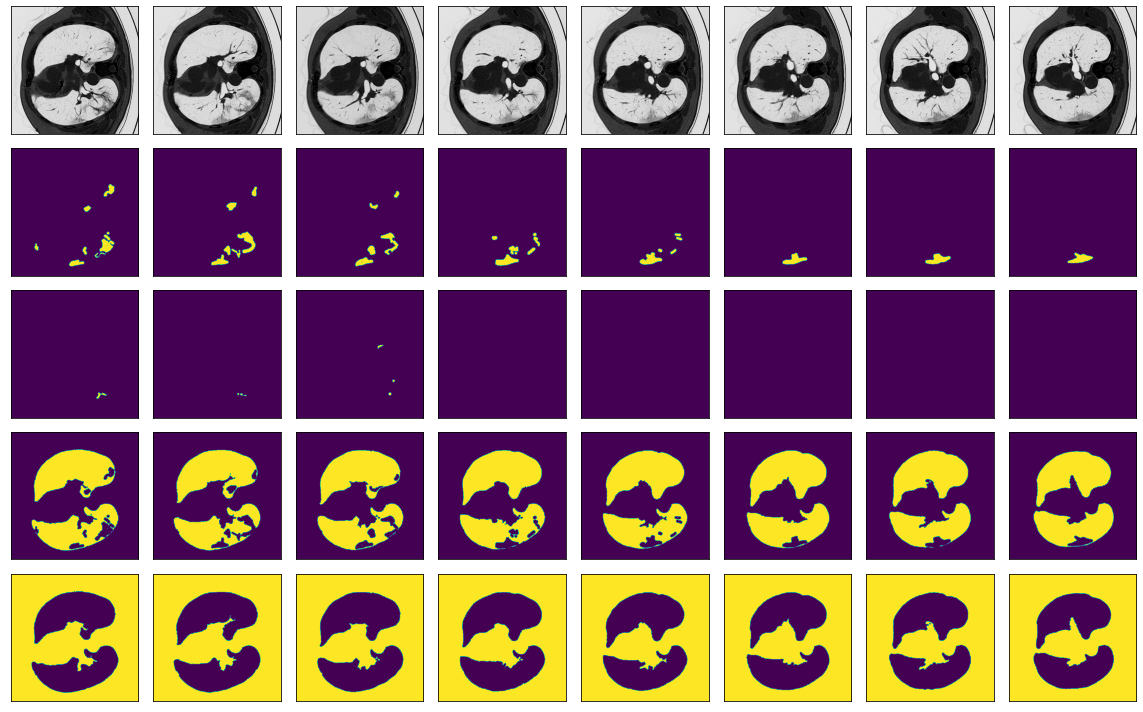

In [5]:
visualize(images_radiopedia[30:], masks_radiopedia[30:])

Hot encoded mask size:  (829, 512, 512, 4)
Paletted mask size: (100, 512, 512)


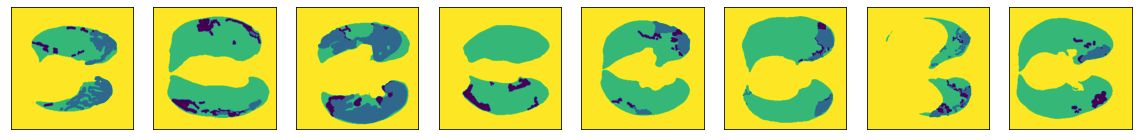

In [6]:
def onehot_to_mask(mask, palette):
    """
    Converts a mask (H, W, K) to (H, W, C)
    """
    x = np.argmax(mask, axis=-1)
    colour_codes = np.array(palette)
    x = np.uint8(colour_codes[x.astype(np.uint8)])
    return x

palette = [[0], [1], [2],[3]]
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)

masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)

print('Hot encoded mask size: ',masks_radiopedia.shape)
print('Paletted mask size:',masks_medseg_recover.shape)

visualize(masks_medseg_recover[30:],hot_encode=False)

### Preprocess images:

In [7]:
def preprocess_images(images_arr, mean_std=None):
    images_arr[images_arr > 500] = 500
    images_arr[images_arr < -1500] = -1500
    min_perc, max_perc = np.percentile(images_arr, 5), np.percentile(images_arr, 95)
    images_arr_valid = images_arr[(images_arr > min_perc) & (images_arr < max_perc)]
    mean, std = (images_arr_valid.mean(), images_arr_valid.std()) if mean_std is None else mean_std
    images_arr = (images_arr - mean) / std
    print(f'mean {mean}, std {std}')
    return images_arr, (mean, std)

images_radiopedia, mean_std = preprocess_images(images_radiopedia)
images_medseg, _ = preprocess_images(images_medseg, mean_std)
test_images_medseg, _ = preprocess_images(test_images_medseg, mean_std)

mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281
mean -451.6488342285156, std 458.5679016113281


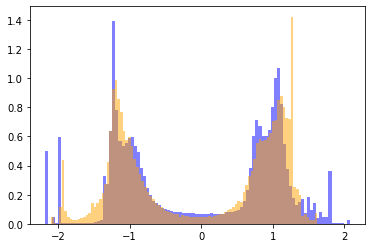

In [8]:
def plot_hists(images1, images2=None):
    plt.hist(images1.ravel(), bins=100, density=True, color='b', alpha=1 if images2 is None else 0.5)
    if images2 is not None:
        plt.hist(images2.ravel(), bins=100, density=True, alpha=0.5, color='orange')
    plt.show();
    
plot_hists(test_images_medseg, images_radiopedia)

## Split train / val:

In [9]:
masks_radiopedia_recover = onehot_to_mask(masks_radiopedia, palette).squeeze()  # shape = (H, W)
masks_medseg_recover = onehot_to_mask(masks_medseg, palette).squeeze()  # shape = (H, W)


val_indexes, train_indexes = list(range(24)), list(range(24, 100))

train_images = np.concatenate((images_medseg[train_indexes], images_radiopedia))
train_masks = np.concatenate((masks_medseg_recover[train_indexes], masks_radiopedia_recover))
val_images = images_medseg[val_indexes]
val_masks = masks_medseg_recover[val_indexes]

batch_size = len(val_masks)

del masks_medseg_recover
del masks_radiopedia_recover
del images_radiopedia
del masks_radiopedia
del images_medseg
del masks_medseg

## Data generator and augmentations:

In [10]:
import tensorflow

import albumentations

import cv2

SOURCE_SIZE = 512
TARGET_SIZE = 256


train_augs = albumentations.Compose([
    albumentations.Rotate(limit=360, p=0.9, border_mode=cv2.BORDER_REPLICATE),
    albumentations.RandomSizedCrop((int(SOURCE_SIZE * 0.75), SOURCE_SIZE), 
                                   TARGET_SIZE, 
                                   TARGET_SIZE, 
                                   interpolation=cv2.INTER_NEAREST),
    albumentations.HorizontalFlip(p=0.5),

])

val_augs = albumentations.Compose([
    albumentations.Resize(TARGET_SIZE, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
])

In [11]:
from PIL import Image
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
import time

from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader  
import torch

device = torch.cuda.set_device(0)

class Dataset:   
    def __init__(
            self, 
            images, 
            masks,
            augmentations=None
    ):
        self.images = images
        self.masks = masks
        self.augmentations = augmentations
        self.mean = [0.485]
        self.std = [0.229]
    
    def __getitem__(self, i):
        image = self.images[i]
        mask = self.masks[i]
        
        
        if self.augmentations is not None:
            sample = self.augmentations(image=image, mask=mask)
            
            image, mask = Image.fromarray(np.squeeze(sample['image'], axis=2)), sample['mask']
        
        if self.augmentations is None:
            image = Image.fromarray(image)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
    
        return image, mask
    
    def __len__(self):
        return len(self.images)
    
    def tiles(self, image, mask):

        img_patches = image.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches
    
                
train_dataset = Dataset(train_images, train_masks, train_augs)
val_dataset = Dataset(val_images, val_masks, val_augs)       

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


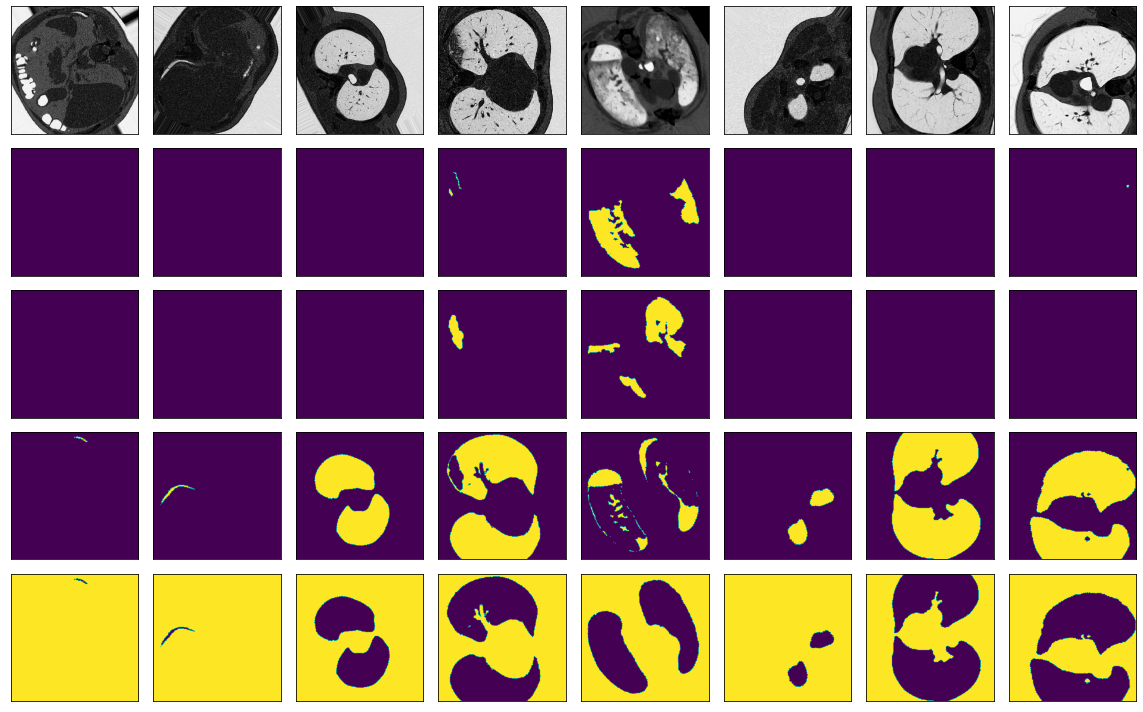

In [12]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        #print('colour',colour)
        equality = np.equal(mask, colour)
        #print('equality',equality)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

i,train_data = next(enumerate(train_dataloader))

mask_hot_encoded = mask_to_onehot(torch.unsqueeze(train_data[1],-1).numpy(),palette)
#visualize(torch.unsqueeze(torch.squeeze(train_data[0],1),-1),mask_hot_encoded)
visualize(train_data[0].permute(0, 2, 3,1),mask_hot_encoded)


In [13]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [14]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=4):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [15]:
def iou(pred, gt):
    pred = pred.squeeze().cpu().data.numpy()
    pred = ToLabel(pred)
    gt = gt.squeeze().cpu().data.numpy()
    agg = pred + gt
    i = float(np.sum(agg == 2))
    u = float(np.sum(agg > 0))
    if u == 0:
        result = 1
    else:
        result = i/u
    return result

In [16]:
model = smp.Unet('efficientnet-b2',in_channels=1, encoder_weights='imagenet',classes=4, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
#decoder_attention_type ='scse'

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth


In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    #torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask =mask_tiles.to(device);
            #forward
            output = model(image)
            
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    image = image_tiles.to(device); mask =mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet_efficientnet_b2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [18]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_dataloader))

history = fit(epoch, model, train_dataloader, val_dataloader, criterion, optimizer, sched)


Loss Decreasing.. inf >> 1.076 
Epoch:1/10.. Train Loss: 1.395.. Val Loss: 1.076.. Train mIoU:0.154.. Val mIoU: 0.278.. Train Acc:0.355.. Val Acc:0.599.. Time: 17.88m



Loss Decreasing.. 1.076 >> 0.543 
Epoch:2/10.. Train Loss: 0.485.. Val Loss: 0.543.. Train mIoU:0.442.. Val mIoU: 0.486.. Train Acc:0.926.. Val Acc:0.892.. Time: 18.36m



Loss Decreasing.. 0.543 >> 0.377 
Epoch:3/10.. Train Loss: 0.153.. Val Loss: 0.377.. Train mIoU:0.599.. Val mIoU: 0.530.. Train Acc:0.976.. Val Acc:0.897.. Time: 18.30m



Loss Decreasing.. 0.377 >> 0.371 
saving model...
Epoch:4/10.. Train Loss: 0.091.. Val Loss: 0.371.. Train mIoU:0.659.. Val mIoU: 0.435.. Train Acc:0.979.. Val Acc:0.849.. Time: 18.37m



Loss Not Decrease for 1 time
Epoch:5/10.. Train Loss: 0.072.. Val Loss: 0.413.. Train mIoU:0.686.. Val mIoU: 0.404.. Train Acc:0.981.. Val Acc:0.814.. Time: 18.46m



Loss Not Decrease for 2 time
Epoch:6/10.. Train Loss: 0.060.. Val Loss: 0.454.. Train mIoU:0.721.. Val mIoU: 0.378.. Train Acc:0.983.. Val Acc:0.805.. Time: 18.35m



Loss Decreasing.. 0.454 >> 0.363 
Epoch:7/10.. Train Loss: 0.056.. Val Loss: 0.363.. Train mIoU:0.734.. Val mIoU: 0.453.. Train Acc:0.984.. Val Acc:0.845.. Time: 18.10m



Loss Decreasing.. 0.363 >> 0.220 
Epoch:8/10.. Train Loss: 0.052.. Val Loss: 0.220.. Train mIoU:0.754.. Val mIoU: 0.593.. Train Acc:0.985.. Val Acc:0.926.. Time: 17.70m



Loss Not Decrease for 3 time
Epoch:9/10.. Train Loss: 0.050.. Val Loss: 0.226.. Train mIoU:0.751.. Val mIoU: 0.583.. Train Acc:0.985.. Val Acc:0.921.. Time: 17.43m



Loss Decreasing.. 0.226 >> 0.200 
Epoch:10/10.. Train Loss: 0.049.. Val Loss: 0.200.. Train mIoU:0.770.. Val mIoU: 0.613.. Train Acc:0.986.. Val Acc:0.932.. Time: 17.95m
Total time: 180.91 m


In [19]:
torch.save(model, 'Unet-efficientnet.pt')

In [20]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

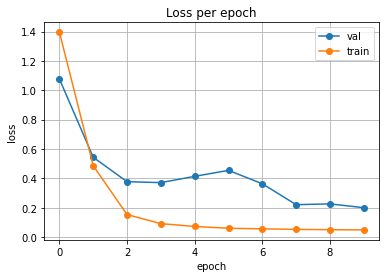

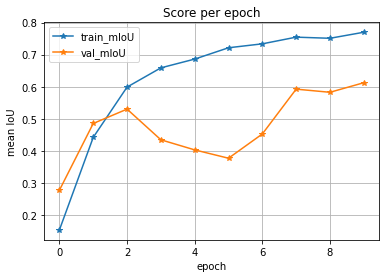

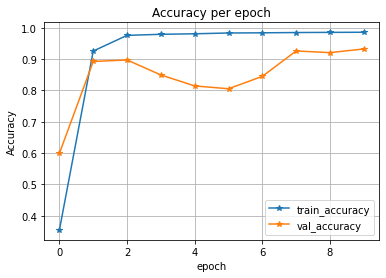

In [21]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation
## Result

In [22]:
def predict_image_mask_miou(model, image, mask, mean=[0.485], std=[0.229]):
    model.eval()
    #t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    #image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    
    
    with torch.no_grad():
        
        #image = image.unsqueeze(0)
        #mask = mask.unsqueeze(0)
        
        output = model(image)
        a,b,c,d = output.shape
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, output.permute(0, 2, 3,1)

In [23]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [24]:
def mask_to_onehot(mask, palette):
    """
    Converts a segmentation mask (H, W, C) to (H, W, K) where the last dim is a one
    hot encoding vector, C is usually 1 or 3, and K is the number of class.
    """
    semantic_map = []
    for colour in palette:
        equality = np.equal(mask, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype(np.float32)
    return torch.from_numpy(semantic_map)

In [25]:
image, mask = next(iter(val_dataloader))
pred_mask, score,output = predict_image_mask_miou(model, image, mask)
semantic_map = mask_to_onehot(torch.unsqueeze(mask,-1).numpy(),palette)

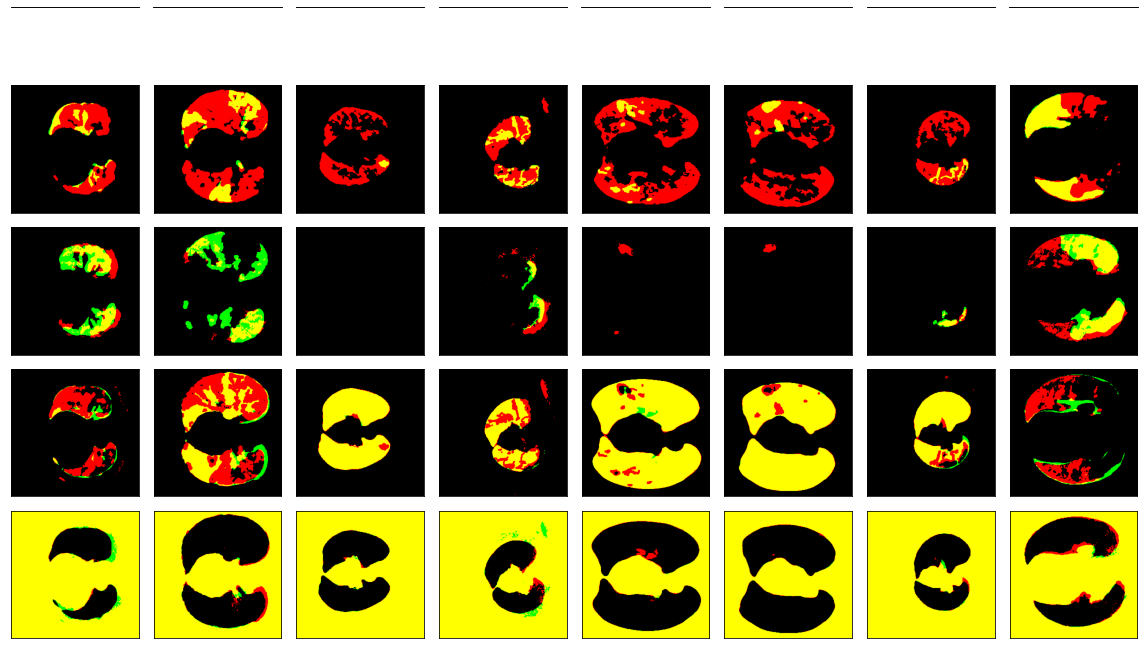

In [26]:
visualize(image, semantic_map, pred_batch=output)

# yellow is TP, red is FP, green is FN

In [27]:
def miou_score(model, test_set):
    score_iou = []
    for i, data in enumerate(tqdm(test_set)):
        img, mask = data
        pred_mask, score,output = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [28]:
mob_miou = miou_score(model, val_dataloader)
mob_miou

[0.6125842828184682]

In [29]:
del train_images
del train_masks

## Test preds:

In [54]:
def test_predict(model, image, mean=[0.485], std=[0.229]):
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.eval()
    
    model.to(device); image=image.to(device)
    
    with torch.no_grad():
        output = model(torch.unsqueeze(image,1))
        output = nn.Softmax(dim=1)(output)
    return output.permute(0, 2, 3,1)

torch.Size([10, 256, 256, 1])
(256, 256, 1)
(10, 256, 256, 4)


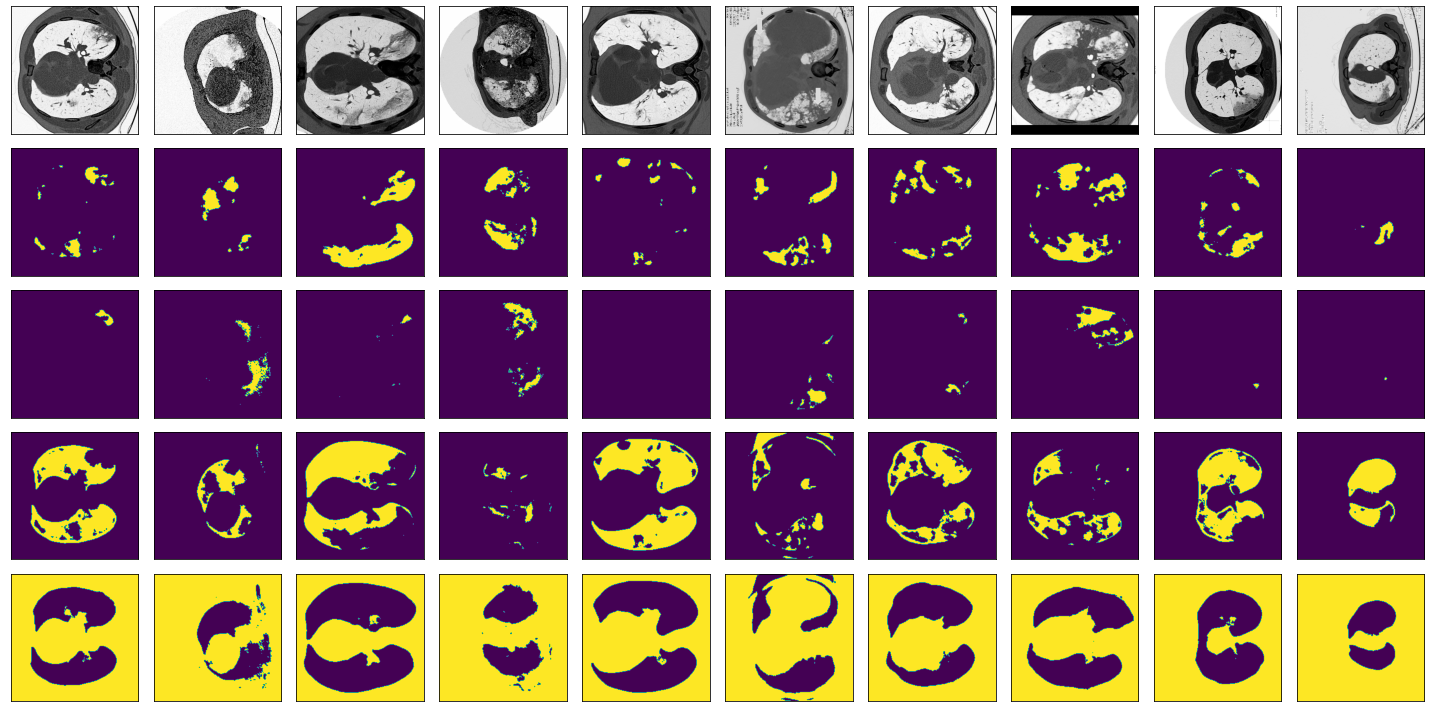

In [55]:
image_batch = np.stack([val_augs(image=img)['image'] for img in test_images_medseg], axis=0)
print(torch.from_numpy(image_batch).shape)
print(image_batch[i].shape)
#output = test_predict(model, torch.from_numpy(image_batch).permute(0, 3, 1,2))
output = np.zeros((10,256,256,4))
for i in range(10):   
    output[i] = test_predict(model, image_batch[i])
print(output.shape)
test_masks_prediction = output > 0.5
visualize(image_batch, test_masks_prediction, num_samples=len(test_images_medseg))

## Resize prediction to original size:

In [51]:
import scipy
test_masks_prediction_original_size = scipy.ndimage.zoom(test_masks_prediction[..., :-2], (1, 2, 2, 1), order=0)
test_masks_prediction_original_size.shape

(10, 512, 512, 2)

In [53]:
import pandas as pd

pd.DataFrame(
             data=np.stack((np.arange(len(test_masks_prediction_original_size.ravel())), 
                            test_masks_prediction_original_size.ravel().astype(int)),
                            axis=-1), 
             columns=['Id', 'Predicted'])\
.set_index('Id').to_csv('sub.csv')